In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

In [4]:
df = pd.read_csv("Data/Raw/HousingData.csv")

In [5]:
#Check the dataframe number of rows and columns

df.shape

(506, 14)

In [25]:
#Checking the null values of each columns

print(df.isnull().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [32]:
#Dealing with the null values

df["CRIM"] = df["CRIM"].fillna(df["CRIM"].mean())
df["ZN"] = df["ZN"].fillna(0)
df["INDUS"] = df["INDUS"].fillna(df["INDUS"].mean())
df["AGE"] = df["AGE"].fillna(df["AGE"].mean())
df["LSTAT"] = df["LSTAT"].fillna(df["LSTAT"].mean())

In [33]:
#dealing the null values of CHAS

null_mask = df['CHAS'].isnull()
num_nulls = null_mask.sum()
num_ones = int(num_nulls * 0.02)
num_zeros = num_nulls - num_ones
replacements = [1] * num_ones + [0] * num_zeros
np.random.shuffle(replacements)
df.loc[null_mask, 'CHAS'] = replacements
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [28]:
#Create a function to get the outliers

def identify_outliers(df):
    outliers = pd.DataFrame(index=df.index)
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
        outliers[column] = outlier_mask
    return outliers

outliers = identify_outliers(df)

#Remove the outliers

df_no_outliers = df[~outliers.any(axis=1)]

In [29]:
#Percentage of outliers in each column

for k, v in df.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1
    v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.4f%%" % (k, perc))

Column CRIM outliers = 12.6482%
Column ZN outliers = 100.0000%
Column INDUS outliers = 0.0000%
Column CHAS outliers = 100.0000%
Column NOX outliers = 0.0000%
Column RM outliers = 5.9289%
Column AGE outliers = 0.0000%
Column DIS outliers = 0.9881%
Column RAD outliers = 0.0000%
Column TAX outliers = 0.0000%
Column PTRATIO outliers = 2.9644%
Column B outliers = 15.2174%
Column LSTAT outliers = 2.3715%
Column MEDV outliers = 7.9051%


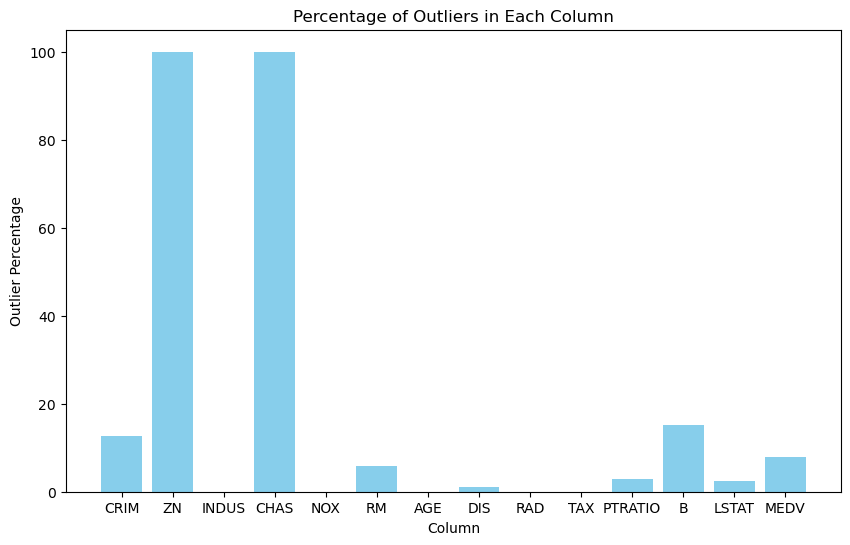

In [30]:
#create a list with the outliers

outliers_list = []

for k, v in df.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    outliers_list.append({'Column': k, 'Outlier_Percentage': perc})

outliers_data = pd.DataFrame(outliers_list)

# create a bar chart to visualize the outliers
plt.figure(figsize=(10, 6))
plt.bar(outliers_data['Column'], outliers_data['Outlier_Percentage'], color='skyblue')
plt.xlabel('Column')
plt.ylabel('Outlier Percentage')
plt.title('Percentage of Outliers in Each Column')
plt.show()

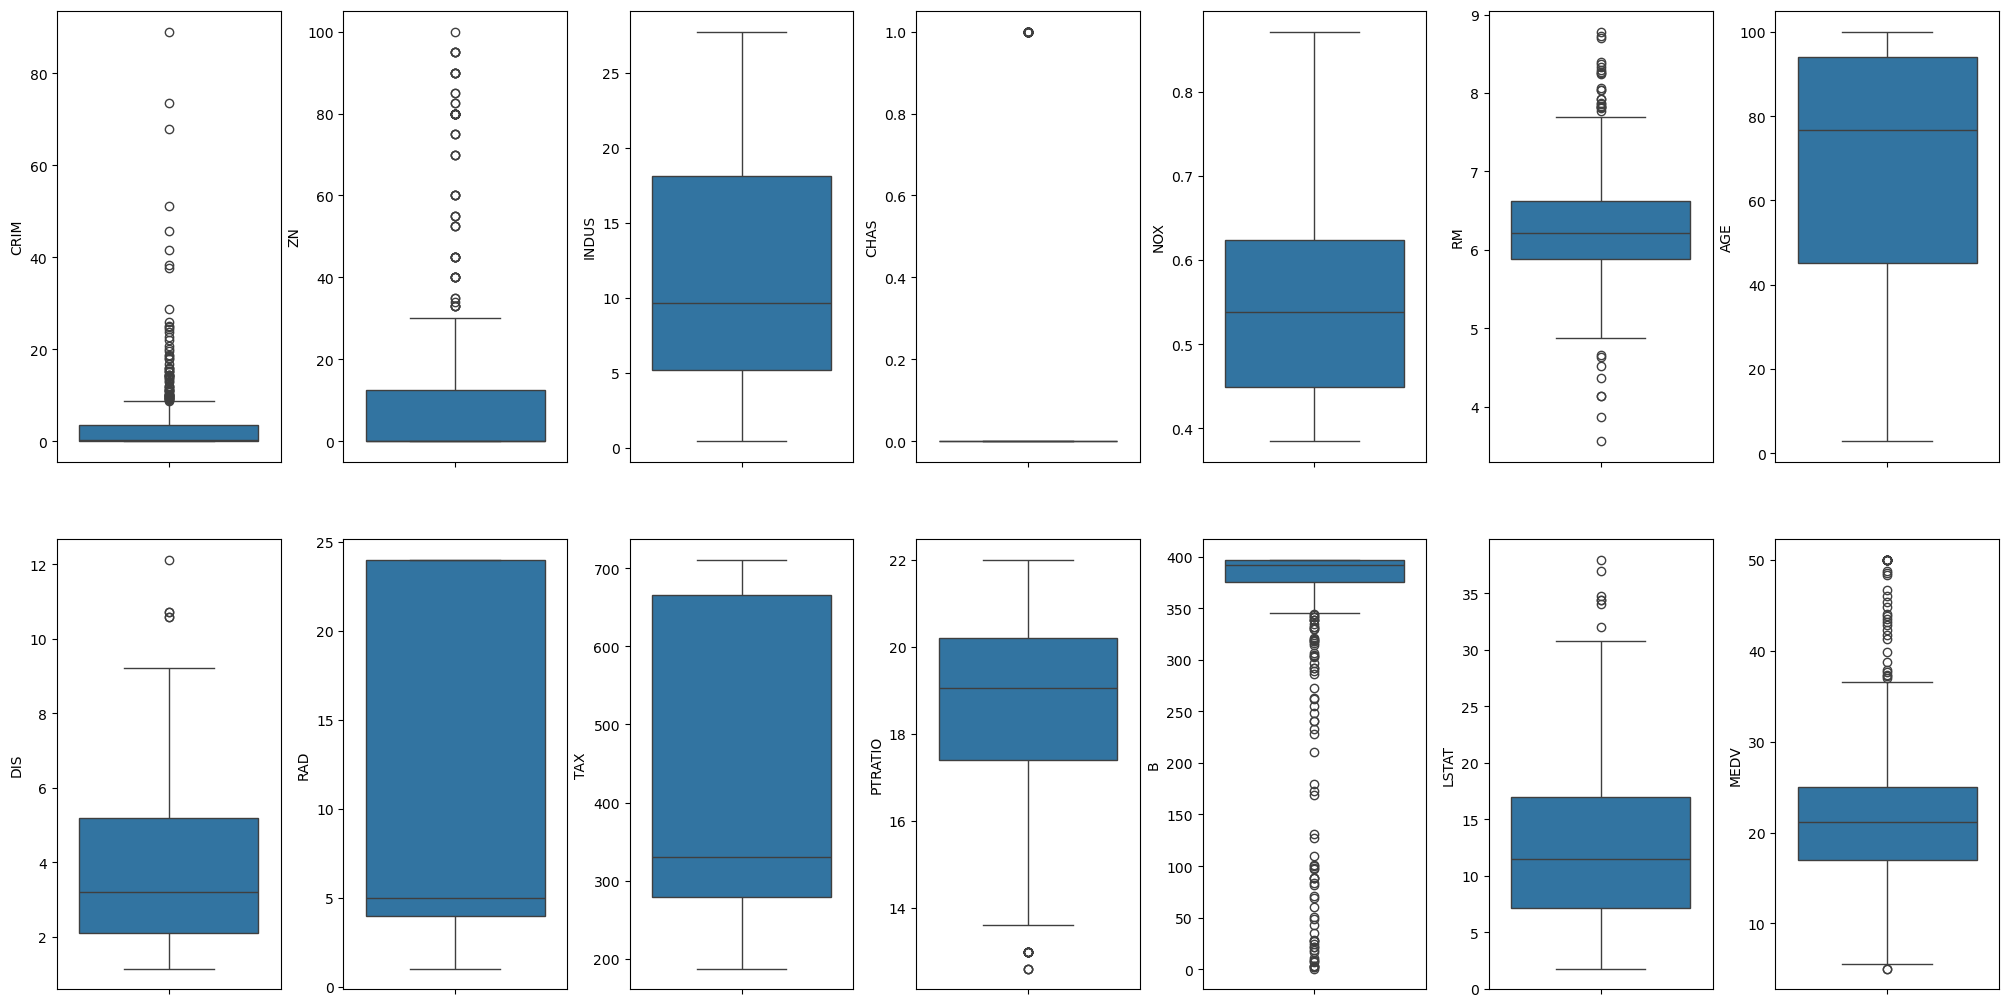

In [8]:
#Create boxplot of each column in order to have a better look into outliers and the tendency values just to see if I can discard any of the columns due to the skews

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

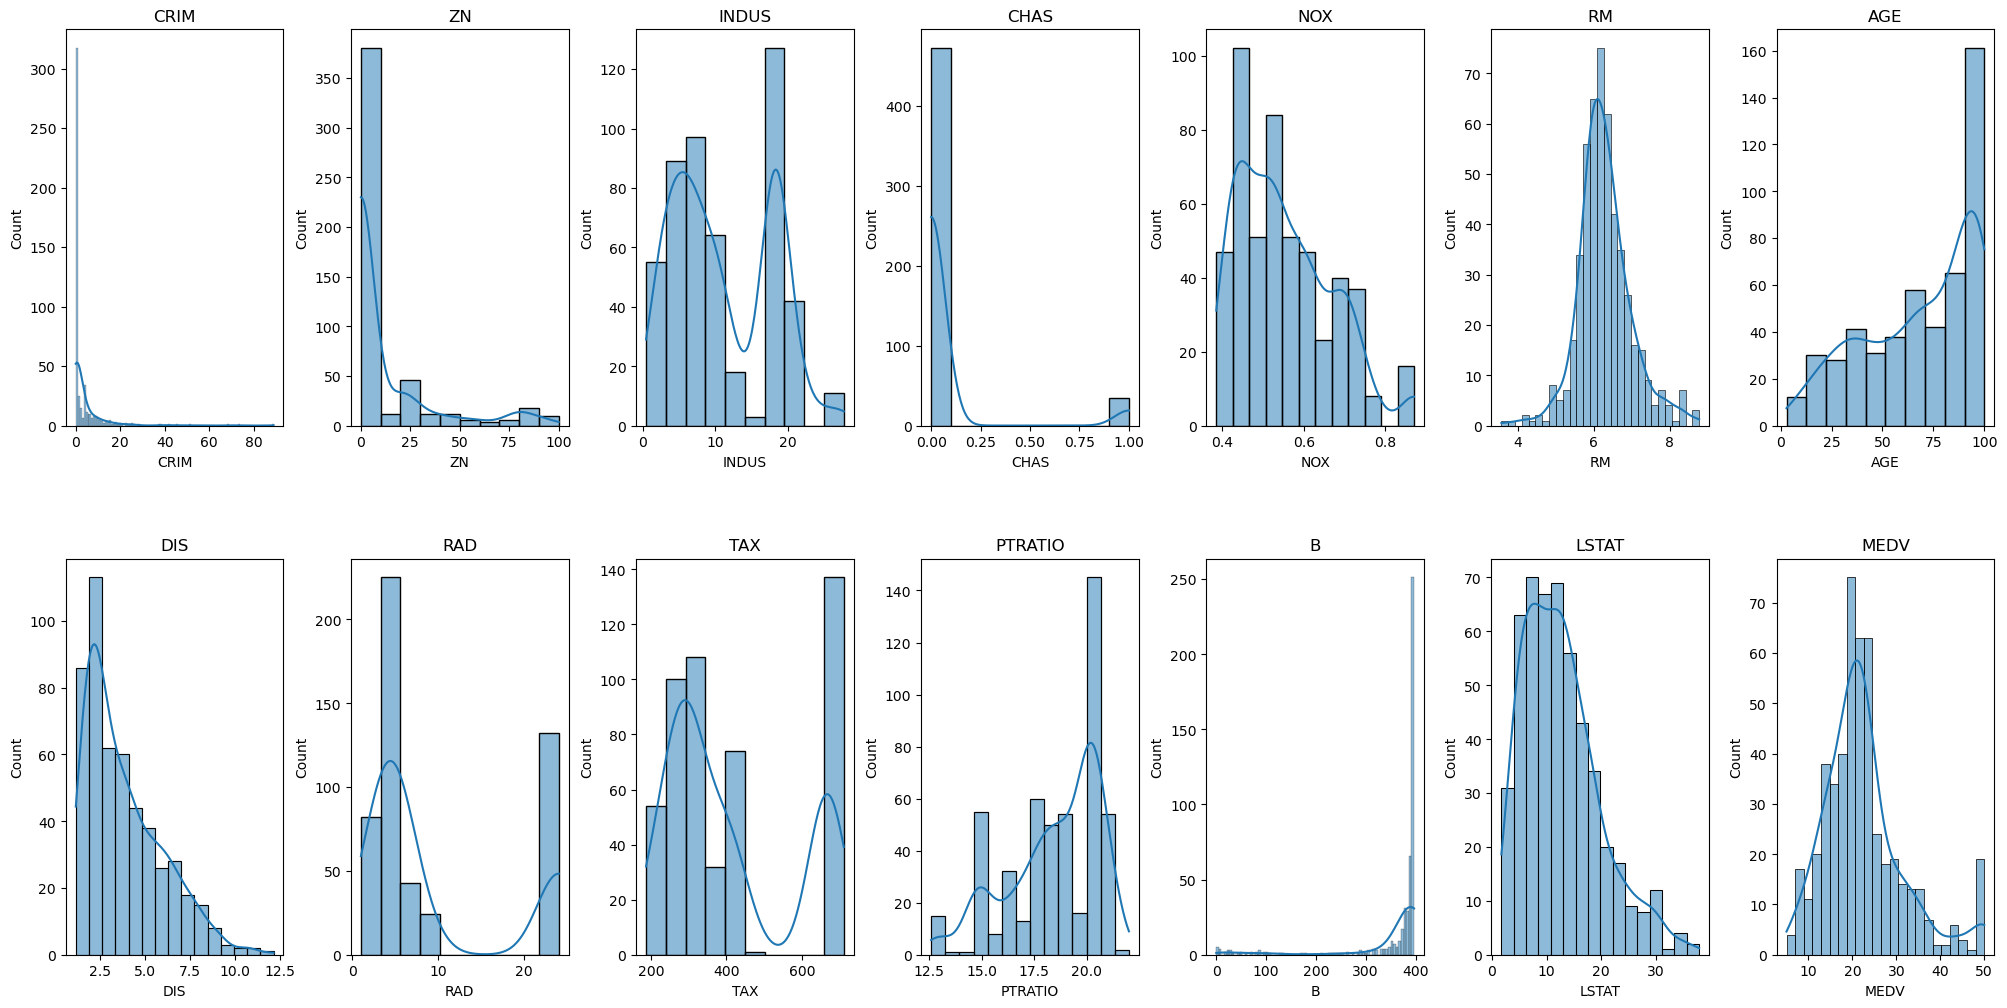

In [14]:
#another perspective of the values using histplot with the KDE

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
axs = axs.flatten()

for index, (k, v) in enumerate(df.items()):
    sns.histplot(v, kde=True, ax=axs[index], label=k)
    axs[index].set_title(k)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

<Axes: >

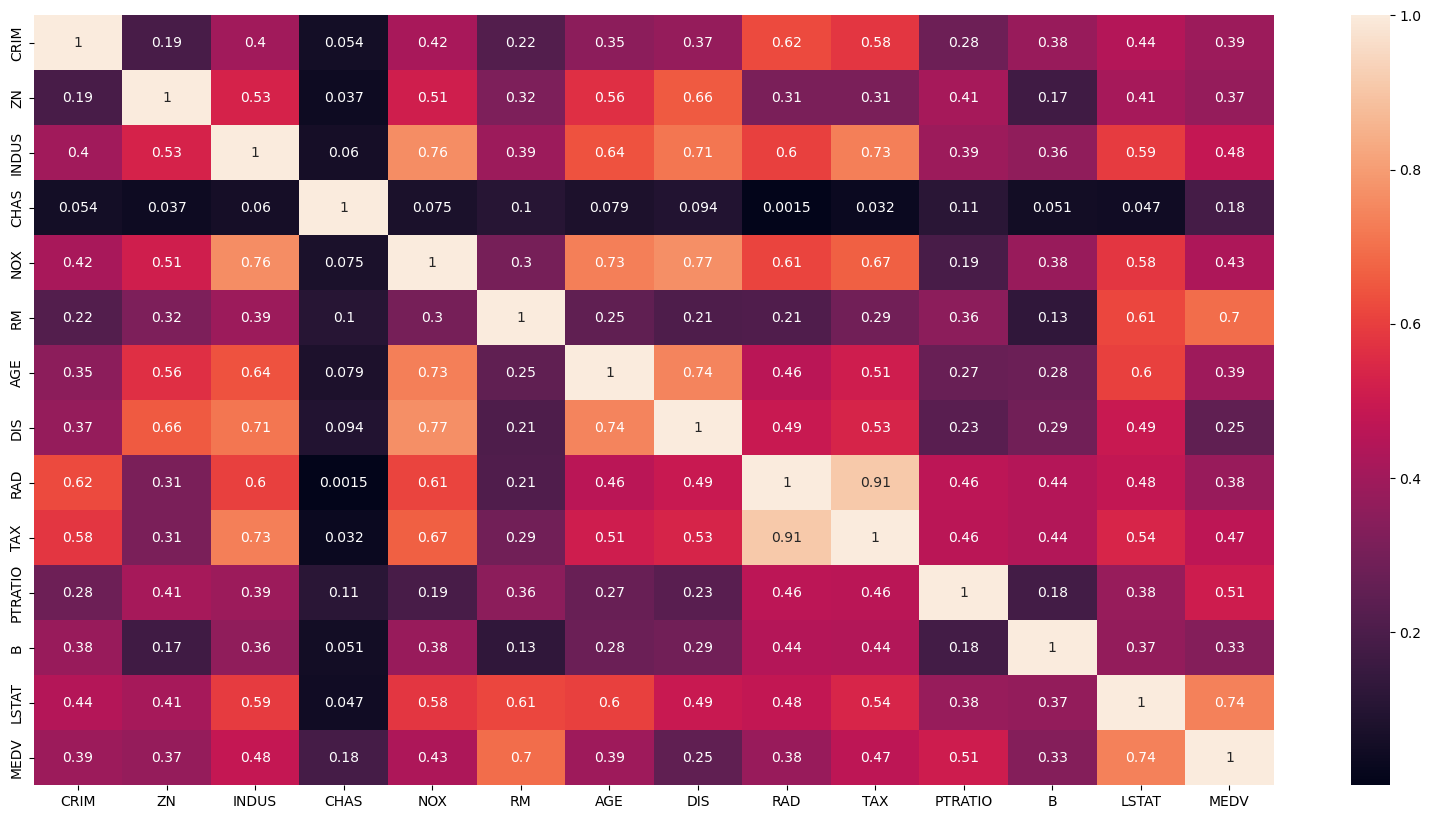

In [9]:
#Create a headmap of correlation

plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

In [34]:
features = df.drop(columns = ["CRIM", "ZN", "CHAS", "RAD", "B", "MEDV", "AGE"])
target = df["MEDV"]

In [35]:
#TTS

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=30)

In [36]:
#normalization of the values in the new columns

normalizer = MinMaxScaler()

normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [37]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)

X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [38]:
#training KNN

knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train_norm, y_train)

print(f"The R2 of the model on the TEST set is: {knn.score(X_test_norm, y_test): .2f}")

The R2 of the model on the TEST set is:  0.69


In [39]:
#linear regression model

lin_reg = LinearRegression()

lin_reg.fit(X_train_norm, y_train)

pred = lin_reg.predict(X_test_norm)

print(f"MAE {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE, {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score, {lin_reg.score(X_test_norm, y_test): .2f}")

MAE  3.45
RMSE,  4.55
R2 score,  0.67


C:\Users\ivanj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
#bagging and pasting

bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=15),
                               n_estimators=140,
                               max_samples = 300)

bagging_reg.fit(X_train_norm, y_train)

pred = bagging_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print(F"R2 score, {bagging_reg.score(X_test_norm, y_test): .2F}")

MAE 1.993526059843976
RMSE 2.724017467194565
R2 score,  0.88


C:\Users\ivanj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
#Random forest method

forest = RandomForestRegressor(n_estimators=140,
                             max_depth=15)

forest.fit(X_train_norm, y_train)

pred = forest.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print(F"R2 score, {forest.score(X_test_norm, y_test): .3F}")

MAE 2.0063697166156804
RMSE 2.7200754004601135
R2 score,  0.884


C:\Users\ivanj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


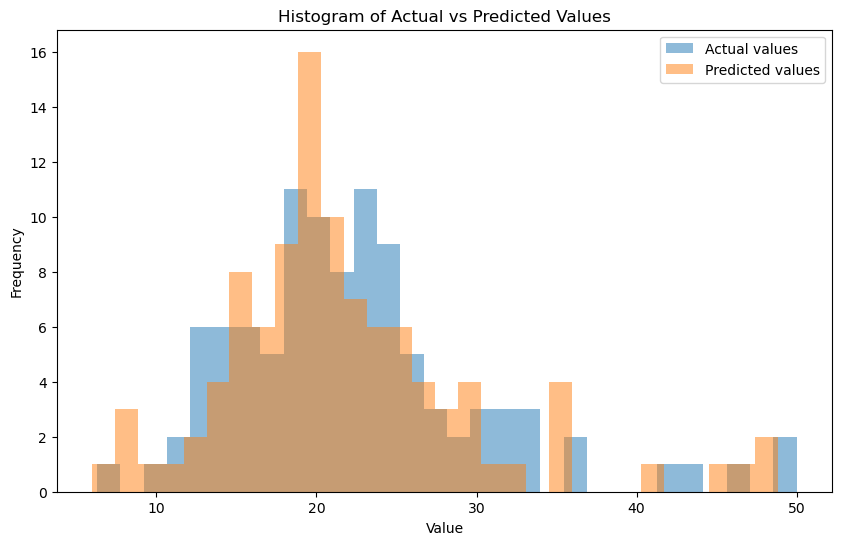

In [41]:
#Create an histogram of the prediction vs actual values
y_test = np.array(y_test)
pred = np.array(pred)

# Plot the histograms
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, label='Actual values')
plt.hist(pred, bins=30, alpha=0.5, label='Predicted values')

# Add title and labels
plt.title('Histogram of Actual vs Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show plot
plt.show()

In [20]:
#grid search to see the optimal hyperparameters

grid = {"max_leaf_nodes": [100, 110, 120, 130, 140, 150],
        "max_depth":[13, 14, 15, 16, 17, 18, 19, 20]}

dt = DecisionTreeRegressor()

model = GridSearchCV(estimator = dt, param_grid = grid, cv=5, verbose=10) # The "cv" option here is used to provide the desired number of folds K.



In [21]:
model.fit(X_train_norm, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START max_depth=13, max_leaf_nodes=100...........................
[CV 1/5; 1/48] END max_depth=13, max_leaf_nodes=100;, score=0.679 total time=   0.0s
[CV 2/5; 1/48] START max_depth=13, max_leaf_nodes=100...........................
[CV 2/5; 1/48] END max_depth=13, max_leaf_nodes=100;, score=0.768 total time=   0.0s
[CV 3/5; 1/48] START max_depth=13, max_leaf_nodes=100...........................
[CV 3/5; 1/48] END max_depth=13, max_leaf_nodes=100;, score=0.841 total time=   0.0s
[CV 4/5; 1/48] START max_depth=13, max_leaf_nodes=100...........................
[CV 4/5; 1/48] END max_depth=13, max_leaf_nodes=100;, score=0.769 total time=   0.0s
[CV 5/5; 1/48] START max_depth=13, max_leaf_nodes=100...........................
[CV 5/5; 1/48] END max_depth=13, max_leaf_nodes=100;, score=0.460 total time=   0.0s
[CV 1/5; 2/48] START max_depth=13, max_leaf_nodes=110...........................
[CV 1/5; 2/48] END max_dept

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [13, 14, 15, 16, 17, 18, 19, 20],
                         'max_leaf_nodes': [100, 110, 120, 130, 140, 150]},
             verbose=10)

In [22]:
model.best_params_

{'max_depth': 18, 'max_leaf_nodes': 110}

In [23]:
best_model = model.best_estimator_

pred = best_model.predict(X_test_norm)

print(f"MAE: {mean_absolute_error(pred, y_test): .2f}")
print(f"RMSE: {mean_squared_error(pred, y_test, squared=False): .2f}")
print(f"R2 score:  {best_model.score(X_test_norm, y_test): .2f}")

MAE:  2.75
RMSE:  3.56
R2 score:   0.80


C:\Users\ivanj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
#Create an external file with the trained Machine Learning model

filename = 'finalized_model.sav'
joblib.dump(forest, filename)

['finalized_model.sav']

In [53]:
#Create an external file with the trained scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# Save the fitted scaler
joblib.dump(scaler, "scaler.sav")

['scaler.sav']

In [42]:
features.describe()

,INDUS,NOX,RM,DIS,TAX,PTRATIO,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,11.083992,0.554695,6.284634,3.795043,408.237154,18.455534,12.715432
std,6.699165,0.115878,0.702617,2.105710,168.537116,2.164946,7.012739
min,0.460000,0.385000,3.561000,1.129600,187.000000,12.600000,1.730000
25%,5.190000,0.449000,5.885500,2.100175,279.000000,17.400000,7.230000
50%,9.900000,0.538000,6.208500,3.207450,330.000000,19.050000,11.995000
75%,18.100000,0.624000,6.623500,5.188425,666.000000,20.200000,16.570000
max,27.740000,0.871000,8.780000,12.126500,711.000000,22.000000,37.970000


In [24]:
#Understand the weight of every variable to see the importance of each one

forest.feature_importances_

array([0.00901177, 0.03845857, 0.49981488, 0.09132689, 0.02298989,
       0.02673308, 0.31166492])